<a href="https://colab.research.google.com/github/anuragbantu/DL-Assignment-1/blob/main/Assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

# **Question 1**

The fashion_MNIST dataset is loaded and 1 sample image for each classs is plotted below.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [3]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

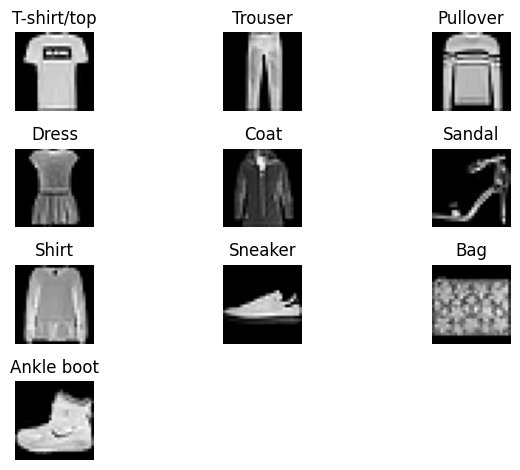

In [4]:
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(4, 3, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(class_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Question 2 & 3**

preparing the dataset.

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.0

In [6]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1

    encoded = np.zeros((len(labels), num_classes))

    encoded[np.arange(len(labels)), labels] = 1

    return encoded

y_train = one_hot_encode(y_train)


In [7]:
y_test = one_hot_encode(y_test)

Define all the activation functions and the necessary loss functions. We will use cross entropy loss for the most part but in Question 8 we will use squared error loss as well.

In [8]:
def sigmoid(x):
  return 0.5 * (1 + np.tanh(0.5 * x))

def sigmoid_d(x):
  s= sigmoid(x)
  return s*(1-s)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True) + 1e-8)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_d(x):
    diag_s = np.diag(x)

    outer_s = np.outer(x, x)
    return diag_s - outer_s

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return np.where(x > 0, 1, 0)

#CCE loss function
def categorical_cross_entropy(y_true, y_pred, layers, weight_decay=0):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
    loss = np.mean(loss)

    l2_penalty = weight_decay * sum(np.sum(layer.weights ** 2) for layer in layers)

    return loss + l2_penalty

#MSE loss
def squared_error_loss(y_true, y_pred):
    return (np.mean(np.sum((y_true - y_pred) ** 2, axis=1))/2)

activations = {"sigmoid":sigmoid,"softmax":softmax,"tanh":tanh,"relu":relu}

derivatives = {"sigmoid":sigmoid_d}





Define a class for layers.

In [9]:
class layer:
  def __init__(self, input, neurons, activation, weight_init):
    if weight_init == "xavier":
        self.weights = np.random.randn(input, neurons) * np.sqrt(1 / input)
    else:
        self.weights = np.random.randn(input, neurons)
    self.bias = np.zeros((1, neurons))
    self.activation = activations[activation]
    self.activation_d = derivatives.get(activation, None)

  #define forward propagation
  def forward(self, a_prev):
    self.a_prev = a_prev
    self.z = np.dot(self.a_prev,self.weights) + self.bias
    self.a = self.activation(self.z)
    return self.a

  #define all the optimization techniques being used
  def sgd(self,w_d,b_d,lr):
    self.weights -= lr*w_d
    self.bias -= lr*b_d

  def momentum_gd(self, w_d, b_d, lr, momentum=0.9):
    if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
    if not hasattr(self, 'm_b'):
        self.m_b = np.zeros_like(self.bias)
    self.m_w = momentum * self.m_w + lr * w_d
    self.m_b = momentum * self.m_b + lr * b_d
    self.weights -= self.m_w
    self.bias -= self.m_b

  def nesterov_gd(self, w_d, b_d, lr, momentum=0.9):
      if not hasattr(self, 'm_w'):
          self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      m_w_prev, m_b_prev = self.m_w, self.m_b
      self.m_w = momentum * self.m_w + lr * w_d
      self.m_b = momentum * self.m_b + lr * b_d
      self.weights -= momentum * m_w_prev + (1 + momentum) * self.m_w
      self.bias -= momentum * m_b_prev + (1 + momentum) * self.m_b

  def rmsprop(self, w_d, b_d, lr, decay_rate=0.9, epsilon=1e-8):
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      self.v_w = decay_rate * self.v_w + (1 - decay_rate) * np.square(w_d)
      self.v_b = decay_rate * self.v_b + (1 - decay_rate) * np.square(b_d)
      self.weights -= lr * w_d / (np.sqrt(self.v_w) + epsilon)
      self.bias -= lr * b_d / (np.sqrt(self.v_b) + epsilon)

  def adam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):

      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0

      self.t += 1

      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      self.weights -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

  def nadam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0
      self.t += 1
      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      m_w_bar = beta1 * m_w_hat + ((1 - beta1) / (1 - beta1**self.t)) * w_d
      m_b_bar = beta1 * m_b_hat + ((1 - beta1) / (1 - beta1**self.t)) * b_d
      self.weights -= lr * m_w_bar / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_bar / (np.sqrt(v_b_hat) + epsilon)


  #define the backpropagation algorithm
  def backprop(self, a_d, lr, optimizer, weight_decay=0):
    if self.activation_d:
      z_d = np.multiply(self.activation_d(self.z),a_d)
    else:
      z_d = a_d

    w_d = np.dot(self.a_prev.T,z_d) + weight_decay * self.weights
    b_d = np.sum(z_d,axis=0,keepdims=True)
    a_prev_d = np.dot(z_d,self.weights.T)

    if optimizer == 'sgd':
            self.sgd(w_d, b_d, lr)
    elif optimizer == 'momentum':
        self.momentum_gd(w_d, b_d, lr)
    elif optimizer == 'nesterov':
        self.nesterov_gd(w_d, b_d, lr)
    elif optimizer == 'rmsprop':
        self.rmsprop(w_d, b_d, lr)
    elif optimizer == 'adam':
        self.adam(w_d, b_d, lr)
    elif optimizer == 'nadam':
        self.nadam(w_d, b_d, lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    return a_prev_d



# Question 3

Implement backpropagation algorithm

# Question 4,5,6


Training different neural entwrok models while using wandb for hyperparamter tuning to find the best performing combinations.

In [10]:
#installing wandb and then logging in
!pip install wandb -Uq

In [11]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [12]:
#setting 10%of the training data aside for validation
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

Setting up the strategy and different parameter values to be analyzed by wandb sweep experiments. Here, we use Bayesian optimization with the goal of maximizing validation accuracy.

In [13]:
#setting the sweep configuration for wandb
import numpy as np

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10, 15]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'fc_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005,0.005,0.05, 0.5]},
        'lr': {'values': [1e-3, 1e-4,1e-5]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")

#defining accuracy metric to measure the model performance
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))





Create sweep with ID: etv8t0qm
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/etv8t0qm


Now, we train the neural networks with different hyperparameter values on the training set. After each epoch, we analyze the performance of the model on the validation set and at the end after all the epochs of training the model we look at the performance on the test dataset. This wandb sweep is run with count=100 which will evaluate 100 different combinations of hyperparameters.

In [14]:
#train the neural network with categorical cross entropy loss

def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config

        #set the model name using all the parameter values
        run_name = (f"hl_{config['num_hidden_layers']}_bs_{config['batch_size']}_ac_{config['activation']}_"
            f"fc_{config['fc_layer_size']}_lr_{config['lr']}_opt_{config['optimizer']}_"
            f"wd_{config['weight_decay']}_wi_{config['weight_init']}_ep_{config['epochs']}")
        wandb.run.name = run_name

        #initialize the 1st input layer
        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]


        #build the subsequent hidden layers and add the last outputlayer
        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        #iterate over epochs
        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            #iterate over batches
            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                #forward propagation
                a = x_batch
                for l in layers:
                    a = l.forward(a)

                #calculate loss and accuracy
                loss = categorical_cross_entropy(y_batch, a,layers, config.weight_decay)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                #backward propagation
                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer, config.weight_decay)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            #calculate the validation loss and accuracy for the epoch
            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = categorical_cross_entropy(y_val, a_val, layers, config.weight_decay)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        #After training, evaluate the model on the test dataset
        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = categorical_cross_entropy(y_test, a_test,layers, config.weight_decay)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})


        #plot the confusion matrices
        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(sweep_id, train_network, count=5)

wandb.finish()


wandb: Agent Starting Run: i78w33dm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 47.894962817292246, Accuracy: 0.10024074074074074, val_loss: 40.585542154342505, val_accuracy: 0.09766666666666667
Epoch 2, Loss: 34.80444183598628, Accuracy: 0.10064814814814815, val_loss: 29.63447121975443, val_accuracy: 0.0995
Epoch 3, Loss: 25.510093603741076, Accuracy: 0.10307407407407407, val_loss: 21.8203690705401, val_accuracy: 0.10316666666666667
Epoch 4, Loss: 18.875006534210492, Accuracy: 0.103, val_loss: 16.240199712321413, val_accuracy: 0.09433333333333334
Epoch 5, Loss: 14.136225920178834, Accuracy: 0.10214814814814815, val_loss: 12.253737722580489, val_accuracy: 0.1055
Epoch 6, Loss: 10.751684176638438, Accuracy: 0.1007962962962963, val_loss: 9.407683249649121, val_accuracy: 0.09716666666666667
Epoch 7, Loss: 8.334690359613587, Accuracy: 0.1, val_loss: 7.376379930060084, val_accuracy: 0.09666666666666666
Epoch 8, Loss: 6.609291850438022, Accuracy: 0.10011111111111111, val_loss: 5.923622854146446, val_accuracy: 0.09433333333333334
Epoch 9, Loss: 5.376929231

accuracy,▅▅██▇▅▄▅▁▂▂▂▂▄▅
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▃▄▇▁█▃▂▁▁▇▂▁▂▇▃
val_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
accuracy,0.10072
epoch,15
loss,2.71071
test_accuracy,0.1


wandb: Agent Starting Run: dqd2xk6h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 333.64787719204713, Accuracy: 0.5934721398933017, val_loss: 331.6496266606547, val_accuracy: 0.7013333333333334
Epoch 2, Loss: 332.34174763041307, Accuracy: 0.7199725844694724, val_loss: 332.44383726693064, val_accuracy: 0.738
Epoch 3, Loss: 333.32616259358525, Accuracy: 0.7439611736810907, val_loss: 333.59529505306284, val_accuracy: 0.7508333333333334
Epoch 4, Loss: 334.2575349534341, Accuracy: 0.7560388263189093, val_loss: 334.8252935799848, val_accuracy: 0.7553333333333333
Epoch 5, Loss: 335.6598926196019, Accuracy: 0.7630964730290456, val_loss: 336.6655185183946, val_accuracy: 0.7523333333333333
Epoch 6, Loss: 337.6444581509841, Accuracy: 0.7642449614700652, val_loss: 338.5658998806778, val_accuracy: 0.7658333333333334
Epoch 7, Loss: 340.0541529392533, Accuracy: 0.7651341138114996, val_loss: 341.7644282398533, val_accuracy: 0.7446666666666667
Epoch 8, Loss: 342.3937717527279, Accuracy: 0.7664493183165383, val_loss: 343.1061719755247, val_accuracy: 0.7696666666666667


accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▂▁▁▂▃▃▅▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▆▇▅██▆
val_loss,▁▁▂▂▃▄▅▆▇█
accuracy,0.77299
epoch,10
loss,347.2123
test_accuracy,0.744


wandb: Agent Starting Run: 9jemb6cb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 3.9431215605598227, Accuracy: 0.10028897451096622, val_loss: 3.920325449624954, val_accuracy: 0.107
Epoch 2, Loss: 3.894804828220543, Accuracy: 0.10931016597510373, val_loss: 3.833028492582778, val_accuracy: 0.12133333333333333
Epoch 3, Loss: 3.6304720607142134, Accuracy: 0.2825466804979253, val_loss: 3.324617597010442, val_accuracy: 0.43566666666666665
Epoch 4, Loss: 3.1393165402191863, Accuracy: 0.5023525489033788, val_loss: 3.0116892290778186, val_accuracy: 0.5235
Epoch 5, Loss: 2.959821917012198, Accuracy: 0.5428460284528749, val_loss: 2.9132968001091815, val_accuracy: 0.5465
Epoch 6, Loss: 2.8880494016248175, Accuracy: 0.5730586840545346, val_loss: 2.8585774122491205, val_accuracy: 0.5828333333333333
Epoch 7, Loss: 2.8485363741781744, Accuracy: 0.604679164196799, val_loss: 2.8252438927369017, val_accuracy: 0.6181666666666666
Epoch 8, Loss: 2.8157851622346546, Accuracy: 0.6405231179608772, val_loss: 2.795155359930273, val_accuracy: 0.6535
Epoch 9, Loss: 2.78430246125

accuracy,▁▁▃▆▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,██▆▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▆▆▇▇▇██
val_loss,█▇▄▃▂▂▁▁▁▁
accuracy,0.70764
epoch,10
loss,2.75992
test_accuracy,0.6805


wandb: Agent Starting Run: oqmnyv98 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 365.1285893881079, Accuracy: 0.16931717081850534, val_loss: 362.2048051346255, val_accuracy: 0.25016666666666665
Epoch 2, Loss: 358.8255390627168, Accuracy: 0.37483318505338076, val_loss: 354.34106987916203, val_accuracy: 0.5015
Epoch 3, Loss: 353.32730415274796, Accuracy: 0.5484319395017794, val_loss: 352.25291749146857, val_accuracy: 0.5711666666666667
Epoch 4, Loss: 352.10421080716577, Accuracy: 0.5915752273625939, val_loss: 351.55779356633735, val_accuracy: 0.5978333333333333
Epoch 5, Loss: 351.5394955001297, Accuracy: 0.6138728252273625, val_loss: 351.0650984326629, val_accuracy: 0.6181666666666666
Epoch 6, Loss: 351.0397704876804, Accuracy: 0.6345887702649269, val_loss: 350.6085805645314, val_accuracy: 0.6371666666666667
Epoch 7, Loss: 350.82873091365, Accuracy: 0.6464882364570977, val_loss: 350.41071830931395, val_accuracy: 0.6485
Epoch 8, Loss: 350.6225926156061, Accuracy: 0.6587089758797944, val_loss: 350.25563160473786, val_accuracy: 0.6596666666666666
Epoch 9,

accuracy,▁▄▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇▇▇██████
val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.70537
epoch,15
loss,350.45384
test_accuracy,0.696


wandb: Agent Starting Run: 1d10o8oz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 862.8027631671146, Accuracy: 0.25063636812969553, val_loss: 856.5813600193676, val_accuracy: 0.4146666666666667
Epoch 2, Loss: 855.2436396498626, Accuracy: 0.4991103202846975, val_loss: 853.0381426762267, val_accuracy: 0.5471666666666667
Epoch 3, Loss: 853.0229439027001, Accuracy: 0.5900368228548833, val_loss: 851.7637816983505, val_accuracy: 0.608
Epoch 4, Loss: 852.2120458325858, Accuracy: 0.6353363483590352, val_loss: 851.2031431188377, val_accuracy: 0.6441666666666667
Epoch 5, Loss: 851.9676484135251, Accuracy: 0.6606366152629497, val_loss: 851.152389765465, val_accuracy: 0.663
Epoch 6, Loss: 852.019558796985, Accuracy: 0.6762492586002372, val_loss: 850.9655820358291, val_accuracy: 0.684
Epoch 7, Loss: 852.0700009238142, Accuracy: 0.6892299327797549, val_loss: 851.1638126626758, val_accuracy: 0.6926666666666667
Epoch 8, Loss: 852.2060310684944, Accuracy: 0.6990905496243575, val_loss: 851.343772056345, val_accuracy: 0.7008333333333333
Epoch 9, Loss: 852.3718179414486,

accuracy,▁▅▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▁▁▁▁▁▁▁▁▂▂▂▂
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇████
val_loss,█▄▂▁▁▁▁▁▂▂▂▃▃▃▃
accuracy,0.73971
epoch,15
loss,853.77602
test_accuracy,0.733


# Question 7

We manually observe the best performing model from the sweep analysis charts based on maximizing test accuracy and evaluate the model again looking at the resulting confusing matrix of the model predictions.

Epoch 1, Loss: 1.475056197946181, Accuracy: 0.7762037037037037
Epoch 2, Loss: 1.8365355520102875, Accuracy: 0.8581111111111112
Epoch 3, Loss: 2.2793891708152705, Accuracy: 0.8722962962962963
Epoch 4, Loss: 2.727527557941748, Accuracy: 0.8810555555555556
Epoch 5, Loss: 3.178527003936262, Accuracy: 0.8888518518518519
Epoch 6, Loss: 3.624743364795535, Accuracy: 0.8917962962962963
Epoch 7, Loss: 4.069069042468316, Accuracy: 0.8967777777777778
Epoch 8, Loss: 4.539729167717409, Accuracy: 0.9004629629629629
Epoch 9, Loss: 4.994609098328842, Accuracy: 0.9043703703703704
Epoch 10, Loss: 5.455295099700861, Accuracy: 0.9072962962962963
Epoch 11, Loss: 5.900137502071147, Accuracy: 0.9107222222222222
Epoch 12, Loss: 6.350158253687913, Accuracy: 0.9131111111111111
Epoch 13, Loss: 6.795109104978981, Accuracy: 0.9157592592592593
Epoch 14, Loss: 7.234652671582917, Accuracy: 0.9188888888888889
Epoch 15, Loss: 7.699204176126935, Accuracy: 0.921037037037037
Test Loss: 8.129532801845292, Test Accuracy: 0.8

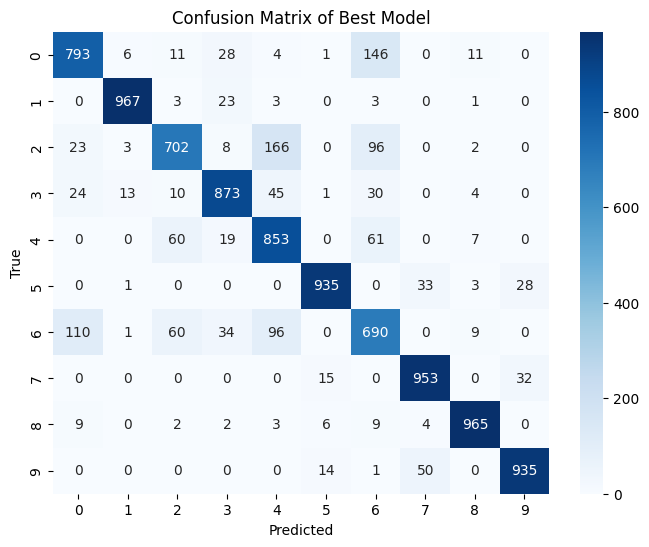

accuracy,▁▅▆▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
test_accuracy,▁
test_loss,▁
accuracy,0.92104
epoch,15
loss,7.6992
test_accuracy,0.8666
test_loss,8.12953


In [15]:
#best model for cross entropy


wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation_0")

best_config = {
    "activation": "sigmoid",
    "batch_size": 16,
    "epochs": 15,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "nadam",
    "weight_decay": 0.0005,
    "weight_init": "xavier"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers, best_config["weight_decay"])
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = categorical_cross_entropy(y_test, a_test, layers, best_config["weight_decay"])
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 8

Now, instead of using cross entropy loss, we will use the squared error loss function and perform a similar wandb sweep as before to identify the best models and the accuracies achieved with this loss function.

In [16]:
#with MSE loss

#define new sweep
new_sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")


def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = squared_error_loss(y_batch, a)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = (a - y_batch) * a * (1 - a)   #derivative of MSE loss with softmax output layer
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = squared_error_loss(y_val, a_val)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = squared_error_loss(y_test, a_test)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(new_sweep_id, train_network, count=5)

wandb.finish()


Create sweep with ID: 43pyec2p
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/43pyec2p


wandb: Agent Starting Run: ahe65zj3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3664122186500214, Accuracy: 0.4583024599881446, val_loss: 0.33685593313936646, val_accuracy: 0.5096666666666667
Epoch 2, Loss: 0.3372699032434918, Accuracy: 0.4821799051570836, val_loss: 0.3382169154337833, val_accuracy: 0.4593333333333333
Epoch 3, Loss: 0.35044934759368296, Accuracy: 0.41916123295791347, val_loss: 0.36251631368213477, val_accuracy: 0.3275
Epoch 4, Loss: 0.3662099058623787, Accuracy: 0.3673681090693539, val_loss: 0.3633355730425983, val_accuracy: 0.3953333333333333
Epoch 5, Loss: 0.37559216514052896, Accuracy: 0.3435647599288678, val_loss: 0.39020139798279174, val_accuracy: 0.2801666666666667
Epoch 6, Loss: 0.39333755810536924, Accuracy: 0.2761003260225252, val_loss: 0.39860535498147676, val_accuracy: 0.2906666666666667
Epoch 7, Loss: 0.40734844974447193, Accuracy: 0.252371072910492, val_loss: 0.4196877700591095, val_accuracy: 0.19166666666666668
Epoch 8, Loss: 0.4189112791491141, Accuracy: 0.1995591286307054, val_loss: 0.42245103231424225, val_accurac

accuracy,██▇▆▅▄▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▃▁▂▃▃▅▅▆██
test_accuracy,▁
test_loss,▁
val_accuracy,█▇▅▆▄▄▃▃▁▂
val_loss,▁▁▃▃▄▅▆▆█▇
accuracy,0.14339
epoch,10
loss,0.44729
test_accuracy,0.1714


wandb: Agent Starting Run: tzlicga0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 0.4767481711488519, Accuracy: 0.10069650266745703, val_loss: 0.4520807099069207, val_accuracy: 0.1055
Epoch 2, Loss: 0.45166673179767036, Accuracy: 0.0995850622406639, val_loss: 0.45176397897408127, val_accuracy: 0.10316666666666667
Epoch 3, Loss: 0.4513429065674144, Accuracy: 0.09930720213396561, val_loss: 0.45092483923119864, val_accuracy: 0.10316666666666667
Epoch 4, Loss: 0.4515083811414287, Accuracy: 0.09951096621221102, val_loss: 0.4516681324483515, val_accuracy: 0.1055
Epoch 5, Loss: 0.4515805971132206, Accuracy: 0.09799199762892709, val_loss: 0.45023084030996474, val_accuracy: 0.09716666666666667
Epoch 6, Loss: 0.45167810066574865, Accuracy: 0.10052978660343806, val_loss: 0.4506633500499832, val_accuracy: 0.09633333333333334
Epoch 7, Loss: 0.4515752667389064, Accuracy: 0.09984439834024897, val_loss: 0.4512433702210302, val_accuracy: 0.098
Epoch 8, Loss: 0.45134813523884126, Accuracy: 0.10012225844694725, val_loss: 0.4505204865869943, val_accuracy: 0.1055
Epoch 9,

accuracy,▇▅▄▅▁▇▅▆▅█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,█▆▆█▂▁▂█▁▁
val_loss,█▇▄▆▁▃▅▂█▆
accuracy,0.10094
epoch,10
loss,0.45127
test_accuracy,0.1


wandb: Agent Starting Run: h26idg0n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 0.4407249493662465, Accuracy: 0.2683928924476078, val_loss: 0.38839750310493676, val_accuracy: 0.37966666666666665
Epoch 2, Loss: 0.3617732013884557, Accuracy: 0.44278865164096476, val_loss: 0.3390140423451086, val_accuracy: 0.4845
Epoch 3, Loss: 0.31648128226834593, Accuracy: 0.5135552589956505, val_loss: 0.3016236696721976, val_accuracy: 0.5325
Epoch 4, Loss: 0.28672682411700434, Accuracy: 0.5577426848556741, val_loss: 0.27627421729115914, val_accuracy: 0.5696666666666667
Epoch 5, Loss: 0.26495029229603717, Accuracy: 0.5954057928034796, val_loss: 0.257467448698053, val_accuracy: 0.605
Epoch 6, Loss: 0.2490161822418432, Accuracy: 0.6217934460260973, val_loss: 0.24435950403139017, val_accuracy: 0.6298333333333334
Epoch 7, Loss: 0.23697913728441336, Accuracy: 0.645431741795176, val_loss: 0.23387753375209938, val_accuracy: 0.648
Epoch 8, Loss: 0.22735696127540117, Accuracy: 0.6632562277580071, val_loss: 0.2250139396437146, val_accuracy: 0.6651666666666667
Epoch 9, Loss: 0.

accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
accuracy,0.68786
epoch,10
loss,0.21283
test_accuracy,0.637


wandb: Agent Starting Run: lr2hsk3d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4153757524297792, Accuracy: 0.2058888888888889, val_loss: 0.4517750123429399, val_accuracy: 0.104
Epoch 2, Loss: 0.4512762302715609, Accuracy: 0.10116666666666667, val_loss: 0.4503515321106117, val_accuracy: 0.0995
Epoch 3, Loss: 0.45127838834858053, Accuracy: 0.09877777777777778, val_loss: 0.4502046504821998, val_accuracy: 0.09633333333333334
Epoch 4, Loss: 0.451390712216443, Accuracy: 0.09887037037037037, val_loss: 0.45010685102160136, val_accuracy: 0.09716666666666667
Epoch 5, Loss: 0.45132948491552055, Accuracy: 0.09803703703703703, val_loss: 0.45083810229810584, val_accuracy: 0.104
Epoch 6, Loss: 0.45133876800337813, Accuracy: 0.09937037037037037, val_loss: 0.45134568530505564, val_accuracy: 0.098
Epoch 7, Loss: 0.4513794797906988, Accuracy: 0.09822222222222222, val_loss: 0.45205128091578806, val_accuracy: 0.10533333333333333
Epoch 8, Loss: 0.45130263238568846, Accuracy: 0.09962962962962962, val_loss: 0.4513040092080466, val_accuracy: 0.09433333333333334
Epoch 9, 

accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁██████████████
test_accuracy,▁
test_loss,▁
val_accuracy,▇▄▂▃▇▃█▁█▂▃▂▄█▂
val_loss,▅▂▁▁▃▄▆▄█▃▄▃▂▅▄
accuracy,0.09819
epoch,15
loss,0.45135
test_accuracy,0.1


wandb: Agent Starting Run: c8yewbvn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4266843674711641, Accuracy: 0.22901220838275999, val_loss: 0.38952364708167503, val_accuracy: 0.3451666666666667
Epoch 2, Loss: 0.3535214118290106, Accuracy: 0.46155842230130484, val_loss: 0.31981548172432417, val_accuracy: 0.5408333333333334
Epoch 3, Loss: 0.2840100801986397, Accuracy: 0.5929838869118229, val_loss: 0.2536368963158731, val_accuracy: 0.628
Epoch 4, Loss: 0.23334793390427888, Accuracy: 0.6598766805061289, val_loss: 0.2212820980164816, val_accuracy: 0.6656666666666666
Epoch 5, Loss: 0.20656001135070723, Accuracy: 0.7083147983392646, val_loss: 0.19671400887561413, val_accuracy: 0.7225
Epoch 6, Loss: 0.18374672186647487, Accuracy: 0.7493945235270858, val_loss: 0.1755067982447948, val_accuracy: 0.7623333333333333
Epoch 7, Loss: 0.16791013206791428, Accuracy: 0.7731934559114275, val_loss: 0.1632617278441585, val_accuracy: 0.7755
Epoch 8, Loss: 0.15806747027368281, Accuracy: 0.7818431198102017, val_loss: 0.15491461905575682, val_accuracy: 0.7816666666666666
Ep

accuracy,▁▄▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.79299
epoch,10
loss,0.14579
test_accuracy,0.7185


As we did for cross entropy, we can analyze the best performing model for the squared error loss function.

Epoch 1, Loss: 0.3890893540449994, Accuracy: 0.27444147884539344
Epoch 2, Loss: 0.19515830988708424, Accuracy: 0.7017286971134835
Epoch 3, Loss: 0.1444124298677204, Accuracy: 0.7903321470937129
Epoch 4, Loss: 0.12641524575299004, Accuracy: 0.8207604290233294
Epoch 5, Loss: 0.11459371794915243, Accuracy: 0.8393201364175563
Epoch 6, Loss: 0.10800411155445672, Accuracy: 0.8494464215104784
Epoch 7, Loss: 0.10013188330417484, Accuracy: 0.8601534697508897
Epoch 8, Loss: 0.09443241440710089, Accuracy: 0.8677219256623172
Epoch 9, Loss: 0.09254553648180146, Accuracy: 0.8707184163701067
Epoch 10, Loss: 0.08824016254198692, Accuracy: 0.8764642645314353
Test Loss: 0.11688452281310559, Test Accuracy: 0.8418


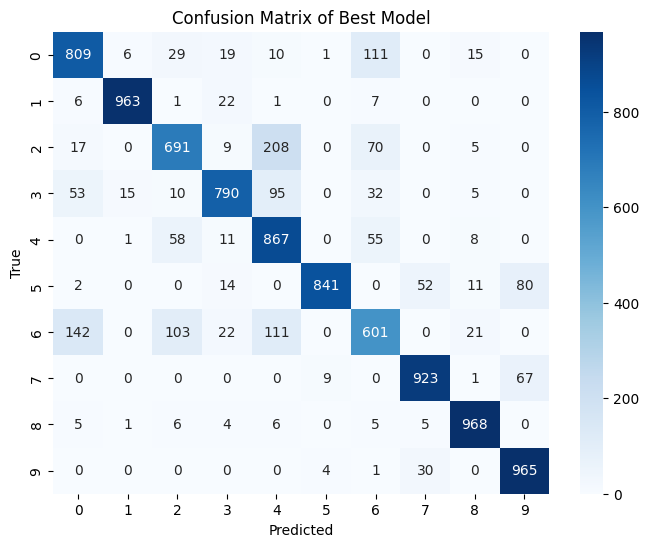

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
accuracy,0.87646
epoch,10
loss,0.08824
test_accuracy,0.8418
test_loss,0.11688


In [17]:
#best model for MSE

wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation")

best_config = {
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 10,
    "fc_layer_size": 64,
    "lr": 0.001,
    "num_hidden_layers": 4,
    "optimizer": "nadam",
    "weight_decay": 0.0005,
    "weight_init": "random"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = squared_error_loss(y_batch, a)
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = squared_error_loss(y_test, a_test)
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 10

Based on our learnings from the experiments on the Fashion-MNIST dataset, we will take 3 of the best performing models and evaluate their performance on the MNIST dataset

In [18]:
from tensorflow.keras.datasets import mnist


In [19]:
(x_1_train, y_1_train), (x_1_test, y_1_test) = mnist.load_data()

x_1_train = x_1_train.reshape(x_1_train.shape[0], 28, 28, 1)
x_1_train = x_1_train.astype('float32') / 255.0

In [20]:
y_1_train = one_hot_encode(y_1_train)
y_1_test = one_hot_encode(y_1_test)

In [21]:
x_train.shape

(54000, 784)

In [22]:
x_1_train.shape

(60000, 28, 28, 1)

In [23]:
rec_config_1 = {
    "activation": "sigmoid",
    "batch_size": 16,
    "epochs": 15,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "nadam",
    "weight_decay": 0.005,
    "weight_init": "xavier"
}

layers = [layer(784, rec_config_1["fc_layer_size"], rec_config_1["activation"], rec_config_1["weight_init"])]
for _ in range(rec_config_1["num_hidden_layers"] - 1):
    layers.append(layer(rec_config_1["fc_layer_size"], rec_config_1["fc_layer_size"], rec_config_1["activation"], rec_config_1["weight_init"]))
layers.append(layer(rec_config_1["fc_layer_size"], 10, "softmax", rec_config_1["weight_init"]))

num_samples = x_1_train.shape[0]

x_1_train = x_1_train.reshape(x_1_train.shape[0], -1)
x_1_test = x_1_test.reshape(x_1_test.shape[0], -1)


for epoch in range(rec_config_1["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_1_train_shuffled = x_1_train[shuffled_indices]
    y_1_train_shuffled = y_1_train[shuffled_indices]

    for start in range(0, num_samples, rec_config_1["batch_size"]):
        end = min(start + rec_config_1["batch_size"], num_samples)
        x_batch = x_1_train_shuffled[start:end]
        y_batch = y_1_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers, rec_config_1["weight_decay"])

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, rec_config_1["lr"], rec_config_1["optimizer"])

a_test = x_1_test
for l in layers:
    a_test = l.forward(a_test)

acc = accuracy(y_1_test, a_test)

print(f"Accuracy on x_1_test: {acc}")
print("Predictions on x_1_test:", y_pred)


Accuracy on x_1_test: 0.9156
Predictions on x_1_test: [9 2 1 ... 8 1 5]


In [24]:
rec_config_2 = {
    "activation": "sigmoid",
    "batch_size": 32,
    "epochs": 5,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "adam",
    "weight_decay": 0.005,
    "weight_init": "xavier"
}

layers_2 = [layer(784, rec_config_2["fc_layer_size"], rec_config_2["activation"], rec_config_2["weight_init"])]
for _ in range(rec_config_2["num_hidden_layers"] - 1):
    layers_2.append(layer(rec_config_2["fc_layer_size"], rec_config_2["fc_layer_size"], rec_config_2["activation"], rec_config_2["weight_init"]))
layers_2.append(layer(rec_config_2["fc_layer_size"], 10, "softmax", rec_config_2["weight_init"]))

num_samples_2 = x_1_train.shape[0]

x_1_train = x_1_train.reshape(x_1_train.shape[0], -1)
x_1_test = x_1_test.reshape(x_1_test.shape[0], -1)

for epoch in range(rec_config_2["epochs"]):
    shuffled_indices = np.random.permutation(num_samples_2)
    x_1_train_shuffled = x_1_train[shuffled_indices]
    y_1_train_shuffled = y_1_train[shuffled_indices]

    for start in range(0, num_samples_2, rec_config_2["batch_size"]):
        end = min(start + rec_config_2["batch_size"], num_samples_2)
        x_batch = x_1_train_shuffled[start:end]
        y_batch = y_1_train_shuffled[start:end]

        a = x_batch
        for l in layers_2:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers_2, rec_config_2["weight_decay"])

        a_d = a - y_batch
        for l in reversed(layers_2):
            a_d = l.backprop(a_d, rec_config_2["lr"], rec_config_2["optimizer"])

a_test = x_1_test
for l in layers_2:
    a_test = l.forward(a_test)

acc = accuracy(y_1_test, a_test)

print(f"Accuracy on x_1_test for rec_config_2: {acc}")
print("Predictions on x_1_test for rec_config_2:", np.argmax(a_test, axis=1))


Accuracy on x_1_test for rec_config_2: 0.9644
Predictions on x_1_test for rec_config_2: [7 2 1 ... 4 5 6]


In [25]:
rec_config_3 = {
    "activation": "relu",
    "batch_size": 64,
    "epochs": 5,
    "fc_layer_size": 32,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "adam",
    "weight_decay": 0.005,
    "weight_init": "xavier"
}

layers_3 = [layer(784, rec_config_3["fc_layer_size"], rec_config_3["activation"], rec_config_3["weight_init"])]
for _ in range(rec_config_3["num_hidden_layers"] - 1):
    layers_3.append(layer(rec_config_3["fc_layer_size"], rec_config_3["fc_layer_size"], rec_config_3["activation"], rec_config_3["weight_init"]))
layers_3.append(layer(rec_config_3["fc_layer_size"], 10, "softmax", rec_config_3["weight_init"]))

num_samples_3 = x_1_train.shape[0]

x_1_train = x_1_train.reshape(x_1_train.shape[0], -1)
x_1_test = x_1_test.reshape(x_1_test.shape[0], -1)

for epoch in range(rec_config_3["epochs"]):
    shuffled_indices = np.random.permutation(num_samples_3)
    x_1_train_shuffled = x_1_train[shuffled_indices]
    y_1_train_shuffled = y_1_train[shuffled_indices]

    for start in range(0, num_samples_3, rec_config_3["batch_size"]):
        end = min(start + rec_config_3["batch_size"], num_samples_3)
        x_batch = x_1_train_shuffled[start:end]
        y_batch = y_1_train_shuffled[start:end]

        a = x_batch
        for l in layers_3:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers_3, rec_config_3["weight_decay"])

        a_d = a - y_batch
        for l in reversed(layers_3):
            a_d = l.backprop(a_d, rec_config_3["lr"], rec_config_3["optimizer"])

a_test = x_1_test
for l in layers_3:
    a_test = l.forward(a_test)

acc = accuracy(y_1_test, a_test)

print(f"Accuracy on x_1_test for rec_config_3: {acc}")
print("Predictions on x_1_test for rec_config_3:", np.argmax(a_test, axis=1))


Accuracy on x_1_test for rec_config_3: 0.9075
Predictions on x_1_test for rec_config_3: [7 2 1 ... 4 5 6]
